In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U pyYAML
!pip install pycm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 9.7 MB/s 
  Attempting uninstall: pyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 3.5 MB/s 
     |████████████████████████████████| 590 kB 14.7 MB/s 


In [3]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import yaml
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pycm import *

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.applications.xception import Xception
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
cfg = yaml.full_load(open("/content/drive/MyDrive/FP/config.yml", 'r'))

In [5]:
train_data = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
test_data = pd.read_csv(cfg['PATHS']['TEST_SET'])
valid_data = pd.read_csv(cfg['PATHS']['VALID_SET'])

In [6]:
test_data.head(5)

,Unnamed: 0,filename,category,category_str
0,0,/content/drive/MyDrive/FP/COVID-19_Radiography...,2,Viral Pneumonia
1,1,/content/drive/MyDrive/FP/COVID-19_Radiography...,1,Covid
2,2,/content/drive/MyDrive/FP/COVID-19_Radiography...,1,Covid
3,3,/content/drive/MyDrive/FP/COVID-19_Radiography...,2,Viral Pneumonia
4,4,/content/drive/MyDrive/FP/COVID-19_Radiography...,0,Normal


In [7]:
train_data.head()

,Unnamed: 0,filename,category,category_str
0,0,/content/drive/MyDrive/FP/COVID-19_Radiography...,1,Covid
1,1,/content/drive/MyDrive/FP/COVID-19_Radiography...,1,Covid
2,2,/content/drive/MyDrive/FP/COVID-19_Radiography...,1,Covid
3,3,/content/drive/MyDrive/FP/COVID-19_Radiography...,2,Viral Pneumonia
4,4,/content/drive/MyDrive/FP/COVID-19_Radiography...,1,Covid


In [8]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


In [9]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category_str',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    seed=42
)


Found 2199 validated image filenames belonging to 3 classes.


In [10]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category_str',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    seed=42
)


Found 733 validated image filenames belonging to 3 classes.


In [11]:
test_data_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_dataframe(
    test_data,
    x_col='filename',
    y_col='category_str',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128,
    shuffle = False,
    seed=42
)

Found 733 validated image filenames belonging to 3 classes.


In [ ]:
xception = Xception(input_shape=(224, 224, 3),
                    weights='imagenet', include_top=False)

for layer in xception.layers:
    layer.trainable = False

top = xception.output
top = MaxPool2D(2)(top)
top = Flatten()(top)
top = Dense(128, activation="relu")(top)
top = Dropout(0.2)(top)
top = Dense(3, activation='softmax')(top)

model = Model(inputs=xception.input, outputs=top)


83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="xceptionmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)
epochs = 30

hist = model.fit_generator(train_generator ,  
                           epochs= epochs, validation_data= valid_generator , callbacks=[es,mc])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 1.5694 - accuracy: 0.7294 
Epoch 1: val_accuracy improved from -inf to 0.80218, saving model to xceptionmodel.h5
18/18 [==============================] - 639s 35s/step - loss: 1.5694 - accuracy: 0.7294 - val_loss: 0.6180 - val_accuracy: 0.8022
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8467
Epoch 2: val_accuracy improved from 0.80218 to 0.88404, saving model to xceptionmodel.h5
18/18 [==============================] - 36s 2s/step - loss: 0.4152 - accuracy: 0.8467 - val_loss: 0.3186 - val_accuracy: 0.8840
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8804
Epoch 3: val_accuracy improved from 0.88404 to 0.88540, saving model to xceptionmodel.h5
18/18 [==============================] - 36s 2s/step - loss: 0.3173 - accuracy: 0.8804 - val_loss: 0.2877 - val_accuracy: 0.8854
Epoch 4/30
18/18 [==============================] - ETA: 0s - lo

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, workers=1)

print("Test accuracy:", test_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test accuracy: 0.8826739192008972


In [12]:
from keras.models import load_model
model = load_model(cfg['PATHS']['XCEPTION'])
# model.save(cfg['PATHS']['XCEPTION'])

### Predicting the Images

In [13]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=-1)
y_pred[:5]

array([2, 0, 0, 2, 1])

In [14]:
test_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

In [15]:
test_labels = test_generator.labels
cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)
cm.print_matrix()

Predict   0         1         2         
Actual
0         198       7         13        

1         22        220       4         

2         1         37        231       




In [16]:
cm.stat(summary=True)

Overall Statistics : 

ACC Macro                                                         0.9236
F1 Macro                                                          0.88614
FPR Macro                                                         0.05722
Kappa                                                             0.82775
Overall ACC                                                       0.8854
PPV Macro                                                         0.8869
SOA1(Landis & Koch)                                               Almost Perfect
TPR Macro                                                         0.8871
Zero-one Loss                                                     84

Class Statistics :

Classes                                                           0             1             2             
ACC(Accuracy)                                                     0.94134       0.9045        0.92497       
AUC(Area under the ROC curve)                                     0.9318  

In [17]:
print(classification_report(test_labels,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       218
           1       0.83      0.89      0.86       246
           2       0.93      0.86      0.89       269

    accuracy                           0.89       733
   macro avg       0.89      0.89      0.89       733
weighted avg       0.89      0.89      0.89       733



### Visualisation

In [18]:
sample_images = test_data.sample(12)["filename"]

In [19]:
def predictec_class(path):
    classes = ["Covid","Normal","Viral Pneumonia"]
    from skimage.transform import resize
    # load image from the path
    img = load_img(path)
    # get the image array
    img_a = img_to_array(img)
    img_a = img_a/255
    img = resize(img_a,(224, 224),anti_aliasing=True)
    img = img.reshape(1, 224, 224, 3)
    probs = model.predict(img)
    predictic_class = classes[np.argmax(probs)]
    probalility = max(probs)
    return predictic_class , probalility


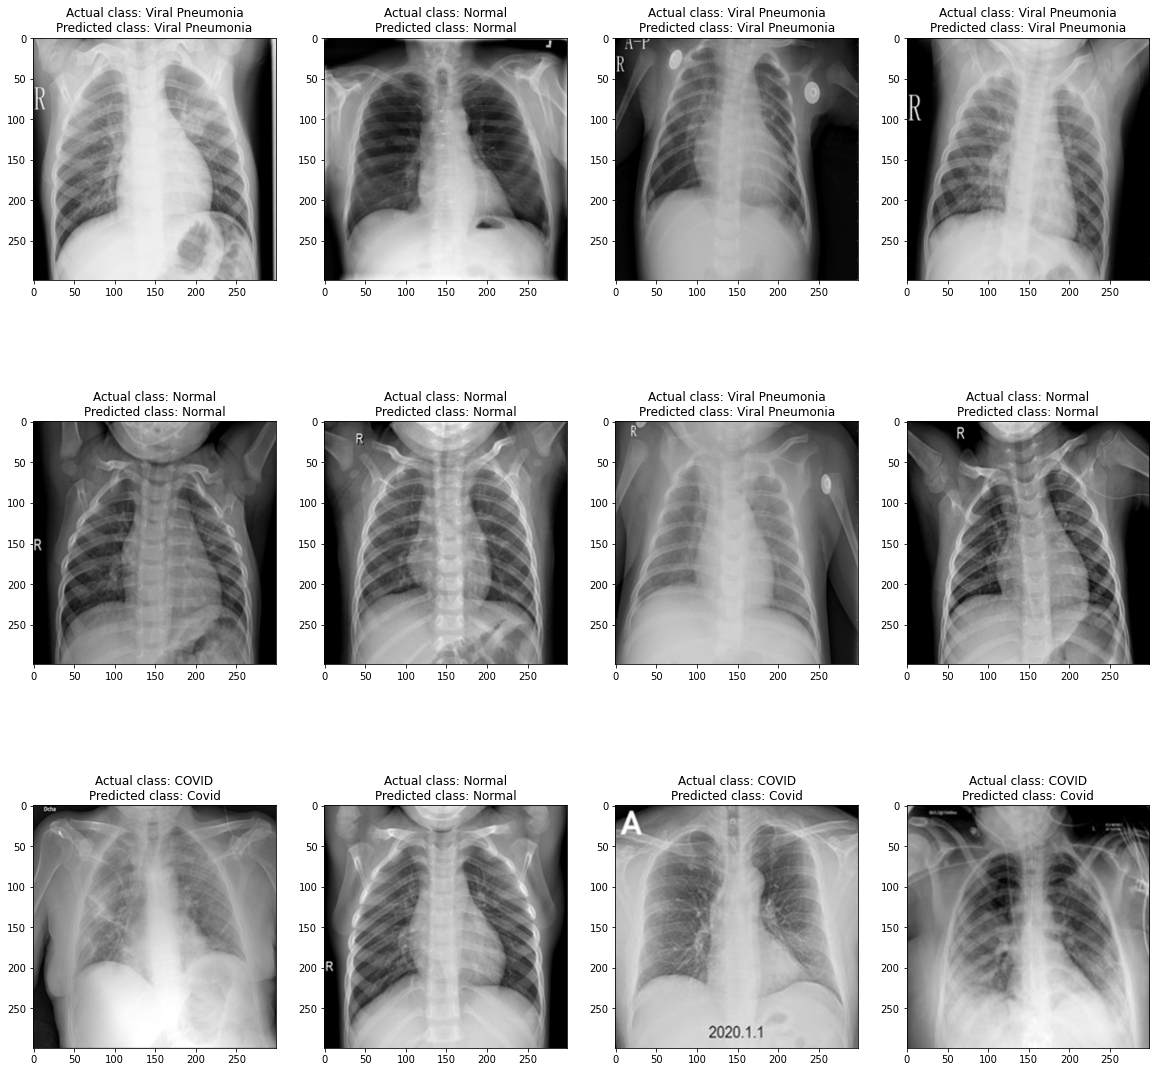

In [20]:
plt.figure(figsize=(20,20))
for i,path in enumerate(sample_images) :
    plt.subplot(3,4,i+1)
    plt.imshow(plt.imread(path),cmap = "gray")
    actual_class = path.split("/")[-1].split("-")[0]
    predicted_class, probalility = predictec_class(path)
    plt.title(f"Actual class: {actual_class}\nPredicted class: {predicted_class}") 